In [46]:
import deepchem as dc

# Load CSV into DataFrame

In [47]:
import pandas as pd
df = pd.read_csv("target_CHEMBL240-1.IC50_ready.csv.gz", compression="gzip")

# Data Pre-processing

In [48]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

# Generate Fingerprints
def generate_morgan_fingerprint(smiles, radius=2, n_bits=2048):
    from rdkit import Chem
    from rdkit.Chem import AllChem
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, n_bits)

df["Morgan"] = df['Standardized_SMILES'].parallel_apply(generate_morgan_fingerprint)

def generate_avalon_fingerprint(smiles, n_bits=2048):
    from rdkit import Chem
    from rdkit.Avalon import pyAvalonTools
    mol = Chem.MolFromSmiles(smiles)
    return pyAvalonTools.GetAvalonFP(mol, nBits=n_bits)

df["Avalon"] = df['Standardized_SMILES'].parallel_apply(generate_avalon_fingerprint)

def generate_maccs_fingerprint(smiles):
    from rdkit import Chem
    from rdkit.Chem import MACCSkeys
    mol = Chem.MolFromSmiles(smiles)
    return MACCSkeys.GenMACCSKeys(mol)

df["MACCS"] = df['Standardized_SMILES'].parallel_apply(generate_maccs_fingerprint)

def generate_tto_fingerprint(smiles, n_bits=2048):
    from rdkit import Chem
    from rdkit.Chem import rdMolDescriptors
    mol = Chem.MolFromSmiles(smiles)
    return rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=n_bits)

df["TTO"] = df['Standardized_SMILES'].parallel_apply(generate_tto_fingerprint)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [49]:
# Compute Tanimoto distances
def calculate_tanimoto_matrix(fp, other_fps):
    from rdkit import DataStructs
    import numpy as np
    return np.array([(1.0 - DataStructs.TanimotoSimilarity(fp, other_fp)
                     ) for other_fp in other_fps])

df["Tanimoto Morgan"] = df["Morgan"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(df["Morgan"]),))

df["Tanimoto Avalon"] = df["Avalon"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(df["Avalon"]),))

df["Tanimoto MACCS"] = df["MACCS"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(df["MACCS"]),))

df["Tanimoto TTO"] = df["TTO"].parallel_apply(calculate_tanimoto_matrix,
                                                    args=(list(df["TTO"]),))

# Convert RDKit Fingerprints to NumPy Arrays

def fingerprint_to_array(fp):
    """Convert RDKit fingerprint to an array."""
    from rdkit import DataStructs
    import numpy as np
    arr = np.zeros((1,), dtype=np.int32)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

df["Morgan"] = df["Morgan"].parallel_apply(fingerprint_to_array)
df["Avalon"] = df["Avalon"].parallel_apply(fingerprint_to_array)
df["MACCS"] = df["MACCS"].parallel_apply(fingerprint_to_array)
df["TTO"] = df["TTO"].parallel_apply(fingerprint_to_array)

In [50]:
# Convert from regression to classification problem
df["target"] = (df['pchembl_value'] >= 7) * 1


# Split Train Test

In [51]:
# Number each row to remember which is which
df["index"] = df.index

# Convert SMILES and index to DeemChem Dataset format
dataset = dc.data.DiskDataset.from_dataframe(df, X="index", ids="Standardized_SMILES")

# Split DeepChem dataset by Scaffolding
train, test = dc.splits.ScaffoldSplitter().train_test_split(dataset, train_size=0.8)

# Obtain row numbers for each set
train_row_numbers = train.X[:,0]
test_row_numbers = test.X[:,0]

# Only keep train set in Tanimoto matrices
df["Tanimoto Morgan"] = df["Tanimoto Morgan"].apply(lambda x: x[train_row_numbers])
df["Tanimoto Avalon"] = df["Tanimoto Avalon"].apply(lambda x: x[train_row_numbers])
df["Tanimoto MACCS"] = df["Tanimoto MACCS"].apply(lambda x: x[train_row_numbers])
df["Tanimoto TTO"] = df["Tanimoto TTO"].apply(lambda x: x[train_row_numbers])

# Extract train set and test set rows
train_df = df.iloc[train_row_numbers]
test_df = df.iloc[test_row_numbers]

# Upper bound (duplicates)

In [52]:
# Find duplicates
smiles_duplicates = df[df["Standardized_SMILES"].duplicated(keep=False)==True]
print("Smiles", len(smiles_duplicates))

def array_to_str(arr):
    return ''.join([str(j) for j in arr])

morgan_string = df["Morgan"].apply(array_to_str)
avalon_string = df["Avalon"].apply(array_to_str)
maccs_string = df["MACCS"].apply(array_to_str)
tto_string = df["TTO"].apply(array_to_str)

morgan_duplicates = df[morgan_string.duplicated(keep=False)==True]
print("Morgan", len(morgan_duplicates))

avalon_duplicates = df[avalon_string.duplicated(keep=False)==True]
print("Avalon", len(avalon_duplicates))

maccs_duplicates = df[maccs_string.duplicated(keep=False)==True]
print("MACCS", len(maccs_duplicates))

tto_duplicates = df[tto_string.duplicated(keep=False)==True]
print("TTO", len(tto_duplicates))

Smiles 348
Morgan 348
Avalon 350
MACCS 788
TTO 348


In [53]:
import numpy as np
# Get mean of each group of duplicates
morgan_duplicates_str = morgan_duplicates["Morgan"].apply(array_to_str)
avalon_duplicates_str = avalon_duplicates["Avalon"].apply(array_to_str)
maccs_duplicates_str = maccs_duplicates["MACCS"].apply(array_to_str)
tto_duplicates_str = tto_duplicates["TTO"].apply(array_to_str)

morgan_means = morgan_duplicates.groupby(morgan_duplicates_str)["target"].mean()
avalon_means = avalon_duplicates.groupby(avalon_duplicates_str)["target"].mean()
maccs_means = maccs_duplicates.groupby(maccs_duplicates_str)["target"].mean()
tto_means = tto_duplicates.groupby(tto_duplicates_str)["target"].mean()

# Replace each duplicate by mean of duplicate group
morgan_predictions_upper = np.array(morgan_means[morgan_duplicates_str])
avalon_predictions_upper = np.array(avalon_means[avalon_duplicates_str])
maccs_predictions_upper = np.array(maccs_means[maccs_duplicates_str])
tto_predictions_upper = np.array(tto_means[tto_duplicates_str])

# Get targets each prediction corresponds to
morgan_targets_upper = morgan_duplicates["target"]
avalon_targets_upper = avalon_duplicates["target"]
maccs_targets_upper = maccs_duplicates["target"]
tto_targets_upper = tto_duplicates["target"]

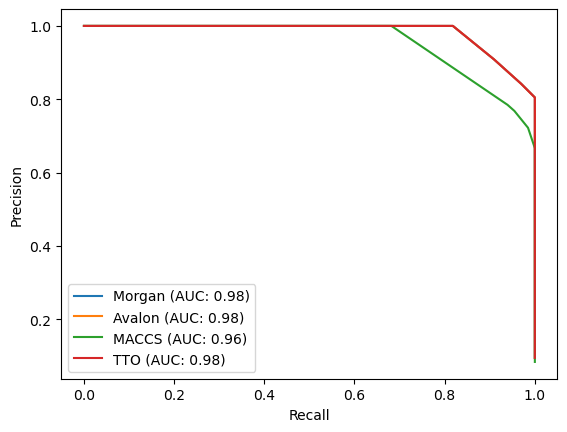

In [54]:
# Get precision recall curves
from sklearn import metrics
morgan_upper_precision, morgan_upper_recall, _ = metrics.precision_recall_curve(
    morgan_targets_upper, morgan_predictions_upper)
morgan_upper_rp_auc = metrics.auc(morgan_upper_recall, morgan_upper_precision)

avalon_upper_precision, avalon_upper_recall, _ = metrics.precision_recall_curve(
    avalon_targets_upper, avalon_predictions_upper)
avalon_upper_rp_auc = metrics.auc(avalon_upper_recall, avalon_upper_precision)

maccs_upper_precision, maccs_upper_recall, _ = metrics.precision_recall_curve(
    maccs_targets_upper, maccs_predictions_upper)
maccs_upper_rp_auc = metrics.auc(maccs_upper_recall, maccs_upper_precision)

tto_upper_precision, tto_upper_recall, _ = metrics.precision_recall_curve(
    tto_targets_upper, tto_predictions_upper)
tto_upper_rp_auc = metrics.auc(tto_upper_recall, tto_upper_precision)

import matplotlib.pyplot as plt

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(morgan_upper_recall, morgan_upper_precision,
         label="Morgan (AUC: " + str(round(morgan_upper_rp_auc*100)/100) + ")")
plt.plot(avalon_upper_recall, avalon_upper_precision,
         label="Avalon (AUC: " + str(round(avalon_upper_rp_auc*100)/100) + ")")
plt.plot(maccs_upper_recall, maccs_upper_precision,
         label="MACCS (AUC: " + str(round(maccs_upper_rp_auc*100)/100) + ")")
plt.plot(tto_upper_recall, tto_upper_precision,
         label="TTO (AUC: " + str(round(tto_upper_rp_auc*100)/100) + ")")
plt.legend()
plt.show()

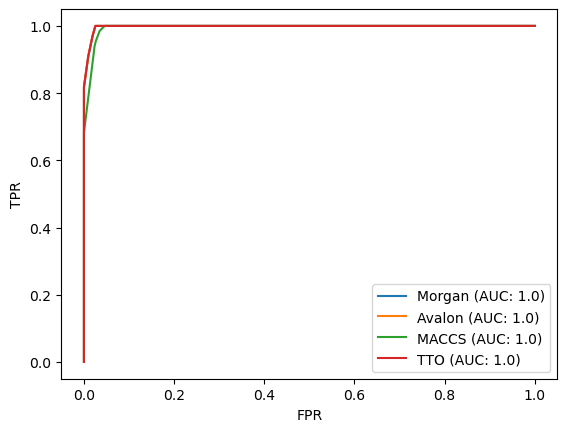

In [55]:
# Get ROC curves
from sklearn import metrics
morgan_upper_fpr, morgan_upper_tpr, _ = metrics.roc_curve(
    morgan_targets_upper, morgan_predictions_upper)
morgan_upper_roc_auc = metrics.auc(morgan_upper_fpr, morgan_upper_tpr)

avalon_upper_fpr, avalon_upper_tpr, _ = metrics.roc_curve(
    avalon_targets_upper, avalon_predictions_upper)
avalon_upper_roc_auc = metrics.auc(avalon_upper_fpr, avalon_upper_tpr)

maccs_upper_fpr, maccs_upper_tpr, _ = metrics.roc_curve(
    maccs_targets_upper, maccs_predictions_upper)
maccs_upper_roc_auc = metrics.auc(maccs_upper_fpr, maccs_upper_tpr)

tto_upper_fpr, tto_upper_tpr, _ = metrics.roc_curve(
    tto_targets_upper, tto_predictions_upper)
tto_upper_roc_auc = metrics.auc(tto_upper_fpr, tto_upper_tpr)

import matplotlib.pyplot as plt

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(morgan_upper_fpr, morgan_upper_tpr,
         label="Morgan (AUC: " + str(round(morgan_upper_roc_auc*100)/100) + ")")
plt.plot(avalon_upper_fpr, avalon_upper_tpr,
         label="Avalon (AUC: " + str(round(avalon_upper_roc_auc*100)/100) + ")")
plt.plot(maccs_upper_fpr, maccs_upper_tpr,
         label="MACCS (AUC: " + str(round(maccs_upper_roc_auc*100)/100) + ")")
plt.plot(tto_upper_fpr, tto_upper_tpr,
         label="TTO (AUC: " + str(round(tto_upper_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

# Lower bound (tanimoto nearest neighbour)

In [56]:
# Get Tanimoto distance matrices

X_train_tanimoto_morgan = np.array(list(train_df["Tanimoto Morgan"]))
X_train_tanimoto_avalon = np.array(list(train_df["Tanimoto Avalon"]))
X_train_tanimoto_maccs = np.array(list(train_df["Tanimoto MACCS"]))
X_train_tanimoto_tto = np.array(list(train_df["Tanimoto TTO"]))

X_test_tanimoto_morgan = np.array(list(test_df["Tanimoto Morgan"]))
X_test_tanimoto_avalon = np.array(list(test_df["Tanimoto Avalon"]))
X_test_tanimoto_maccs = np.array(list(test_df["Tanimoto MACCS"]))
X_test_tanimoto_tto = np.array(list(test_df["Tanimoto TTO"]))

y_train = train_df["target"]
y_test = test_df["target"]

In [57]:
from sklearn.neighbors import KNeighborsClassifier
# Make Nearest Neighbours predictions
def nearest_neighbours(X_train, y_train, X_test):
    nearest = KNeighborsClassifier(n_neighbors = 1, metric="precomputed")
    nearest.fit(X_train, y_train)
    return nearest.predict_proba(X_test)[:,1]

predictions_tanimoto_morgan = nearest_neighbours(
    X_train_tanimoto_morgan, y_train, X_test_tanimoto_morgan)

predictions_tanimoto_avalon = nearest_neighbours(
    X_train_tanimoto_avalon, y_train, X_test_tanimoto_avalon)

predictions_tanimoto_maccs = nearest_neighbours(
    X_train_tanimoto_maccs, y_train, X_test_tanimoto_maccs)

predictions_tanimoto_tto = nearest_neighbours(
    X_train_tanimoto_tto, y_train, X_test_tanimoto_tto)

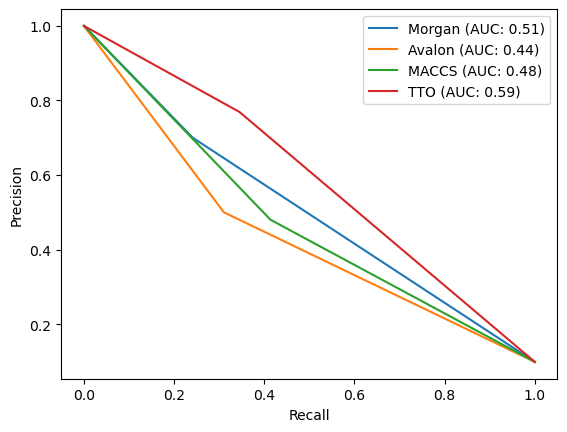

In [58]:
# Get precision recall curves

morgan_lower_precision, morgan_lower_recall, _ = metrics.precision_recall_curve(
    y_test, predictions_tanimoto_morgan)
morgan_lower_rp_auc = metrics.auc(morgan_lower_recall, morgan_lower_precision)

avalon_lower_precision, avalon_lower_recall, _ = metrics.precision_recall_curve(
    y_test, predictions_tanimoto_avalon)
avalon_lower_rp_auc = metrics.auc(avalon_lower_recall, avalon_lower_precision)

maccs_lower_precision, maccs_lower_recall, _ = metrics.precision_recall_curve(
    y_test, predictions_tanimoto_maccs)
maccs_lower_rp_auc = metrics.auc(maccs_lower_recall, maccs_lower_precision)

tto_lower_precision, tto_lower_recall, _ = metrics.precision_recall_curve(
    y_test, predictions_tanimoto_tto)
tto_lower_rp_auc = metrics.auc(tto_lower_recall, tto_lower_precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(morgan_lower_recall, morgan_lower_precision,
         label="Morgan (AUC: " + str(round(morgan_lower_rp_auc*100)/100) + ")")
plt.plot(avalon_lower_recall, avalon_lower_precision,
         label="Avalon (AUC: " + str(round(avalon_lower_rp_auc*100)/100) + ")")
plt.plot(maccs_lower_recall, maccs_lower_precision,
         label="MACCS (AUC: " + str(round(maccs_lower_rp_auc*100)/100) + ")")
plt.plot(tto_lower_recall, tto_lower_precision,
         label="TTO (AUC: " + str(round(tto_lower_rp_auc*100)/100) + ")")
plt.legend()
plt.show()

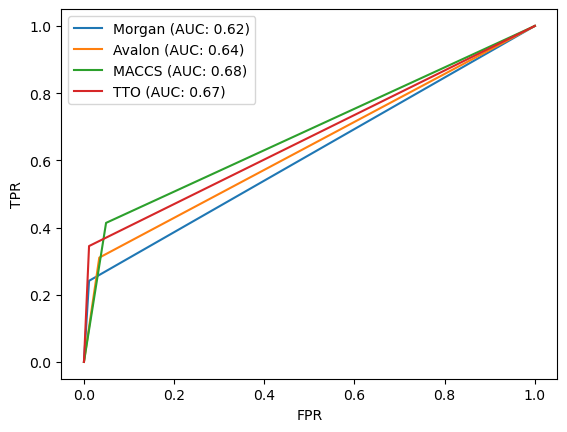

In [59]:
# Get ROC curves
morgan_lower_fpr, morgan_lower_tpr, _ = metrics.roc_curve(
    y_test, predictions_tanimoto_morgan)
morgan_lower_roc_auc = metrics.auc(morgan_lower_fpr, morgan_lower_tpr)

avalon_lower_fpr, avalon_lower_tpr, _ = metrics.roc_curve(
    y_test, predictions_tanimoto_avalon)
avalon_lower_roc_auc = metrics.auc(avalon_lower_fpr, avalon_lower_tpr)

maccs_lower_fpr, maccs_lower_tpr, _ = metrics.roc_curve(
    y_test, predictions_tanimoto_maccs)
maccs_lower_roc_auc = metrics.auc(maccs_lower_fpr, maccs_lower_tpr)

tto_lower_fpr, tto_lower_tpr, _ = metrics.roc_curve(
    y_test, predictions_tanimoto_tto)
tto_lower_roc_auc = metrics.auc(tto_lower_fpr, tto_lower_tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(morgan_lower_fpr, morgan_lower_tpr,
         label="Morgan (AUC: " + str(round(morgan_lower_roc_auc*100)/100) + ")")
plt.plot(avalon_lower_fpr, avalon_lower_tpr,
         label="Avalon (AUC: " + str(round(avalon_lower_roc_auc*100)/100) + ")")
plt.plot(maccs_lower_fpr, maccs_lower_tpr,
         label="MACCS (AUC: " + str(round(maccs_lower_roc_auc*100)/100) + ")")
plt.plot(tto_lower_fpr, tto_lower_tpr,
         label="TTO (AUC: " + str(round(tto_lower_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

# Random Forest

In [60]:
X_train_morgan = np.array(list(train_df["Morgan"]))
X_train_avalon = np.array(list(train_df["Avalon"]))
X_train_maccs = np.array(list(train_df["MACCS"]))
X_train_tto = np.array(list(train_df["TTO"]))

X_test_morgan = np.array(list(test_df["Morgan"]))
X_test_avalon = np.array(list(test_df["Avalon"]))
X_test_maccs = np.array(list(test_df["MACCS"]))
X_test_tto = np.array(list(test_df["TTO"]))


y_train_shuffled = train_df["target"].sample(frac=1).reset_index(drop=True)

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

def rf_model(X_train, y_train, X_test):
    param_grid = { 
        "bootstrap": [True],
        'max_depth' : [80, 90, 100, 110, None],
        'max_features': [2, 3],
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 200, 300, 1000],
    }
    rf = RandomForestClassifier(random_state=42)
    sf = StratifiedKFold(n_splits=4)
    model = GridSearchCV(rf, param_grid, cv=sf)
    model.fit(X_train, y_train)
    print(model.best_params_)
    return model.predict_proba(X_test)[:,1]

rf_predictions_morgan = rf_model(X_train_morgan, y_train, X_test_morgan)
rf_predictions_avalon = rf_model(X_train_avalon, y_train, X_test_avalon)
rf_predictions_maccs = rf_model(X_train_maccs, y_train, X_test_maccs)
rf_predictions_tto = rf_model(X_train_tto, y_train, X_test_tto)

rf_predictions_morgan_shuffled = rf_model(X_train_morgan, y_train_shuffled, X_test_morgan)
rf_predictions_avalon_shuffled = rf_model(X_train_avalon, y_train_shuffled, X_test_avalon)
rf_predictions_maccs_shuffled = rf_model(X_train_maccs, y_train_shuffled, X_test_maccs)
rf_predictions_tto_shuffled = rf_model(X_train_tto, y_train_shuffled, X_test_tto)

{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}
{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 300}
{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
{'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


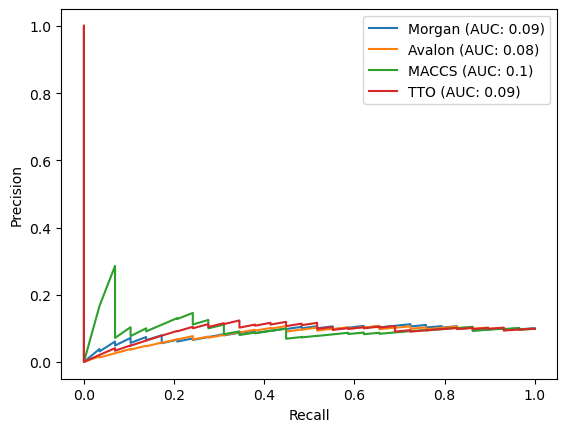

In [67]:
# Get precision recall curves - random basline

morgan_shuffled_precision, morgan_shuffled_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_morgan_shuffled)
morgan_shuffled_rp_auc = metrics.auc(morgan_shuffled_recall, morgan_shuffled_precision)

avalon_shuffled_precision, avalon_shuffled_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_avalon_shuffled)
avalon_shuffled_rp_auc = metrics.auc(avalon_shuffled_recall, avalon_shuffled_precision)

maccs_shuffled_precision, maccs_shuffled_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_maccs_shuffled)
maccs_shuffled_rp_auc = metrics.auc(maccs_shuffled_recall, maccs_shuffled_precision)

tto_shuffled_precision, tto_shuffled_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_tto_shuffled)
tto_shuffled_rp_auc = metrics.auc(tto_shuffled_recall, tto_shuffled_precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(morgan_shuffled_recall, morgan_shuffled_precision,
         label="Morgan (AUC: " + str(round(morgan_shuffled_rp_auc*100)/100) + ")")
plt.plot(avalon_shuffled_recall, avalon_shuffled_precision,
         label="Avalon (AUC: " + str(round(avalon_shuffled_rp_auc*100)/100) + ")")
plt.plot(maccs_shuffled_recall, maccs_shuffled_precision,
         label="MACCS (AUC: " + str(round(maccs_shuffled_rp_auc*100)/100) + ")")
plt.plot(tto_shuffled_recall, tto_shuffled_precision,
         label="TTO (AUC: " + str(round(tto_shuffled_rp_auc*100)/100) + ")")
plt.legend()
plt.show()

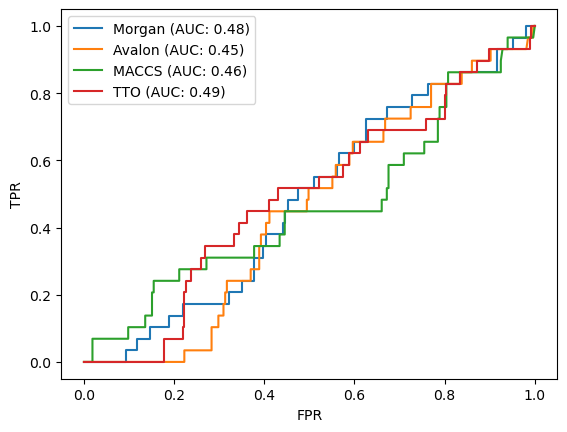

In [68]:
# Get ROC curves - random baseline
morgan_shuffled_fpr, morgan_shuffled_tpr, _ = metrics.roc_curve(
    y_test, rf_predictions_morgan_shuffled)
morgan_shuffled_roc_auc = metrics.auc(morgan_shuffled_fpr, morgan_shuffled_tpr)

avalon_shuffled_fpr, avalon_shuffled_tpr, _ = metrics.roc_curve(
    y_test, rf_predictions_avalon_shuffled)
avalon_shuffled_roc_auc = metrics.auc(avalon_shuffled_fpr, avalon_shuffled_tpr)

maccs_shuffled_fpr, maccs_shuffled_tpr, _ = metrics.roc_curve(
    y_test, rf_predictions_maccs_shuffled)
maccs_shuffled_roc_auc = metrics.auc(maccs_shuffled_fpr, maccs_shuffled_tpr)

tto_shuffled_fpr, tto_shuffled_tpr, _ = metrics.roc_curve(
    y_test, rf_predictions_tto_shuffled)
tto_shuffled_roc_auc = metrics.auc(tto_shuffled_fpr, tto_shuffled_tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(morgan_shuffled_fpr, morgan_shuffled_tpr,
         label="Morgan (AUC: " + str(round(morgan_shuffled_roc_auc*100)/100) + ")")
plt.plot(avalon_shuffled_fpr, avalon_shuffled_tpr,
         label="Avalon (AUC: " + str(round(avalon_shuffled_roc_auc*100)/100) + ")")
plt.plot(maccs_shuffled_fpr, maccs_shuffled_tpr,
         label="MACCS (AUC: " + str(round(maccs_shuffled_roc_auc*100)/100) + ")")
plt.plot(tto_shuffled_fpr, tto_shuffled_tpr,
         label="TTO (AUC: " + str(round(tto_shuffled_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

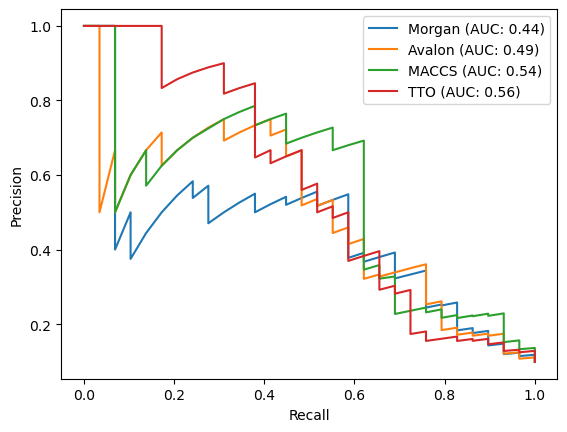

In [69]:
# Get precision recall curves

morgan_precision, morgan_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_morgan)
morgan_rp_auc = metrics.auc(morgan_recall, morgan_precision)

avalon_precision, avalon_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_avalon)
avalon_rp_auc = metrics.auc(avalon_recall, avalon_precision)

maccs_precision, maccs_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_maccs)
maccs_rp_auc = metrics.auc(maccs_recall, maccs_precision)

tto_precision, tto_recall, _ = metrics.precision_recall_curve(
    y_test, rf_predictions_tto)
tto_rp_auc = metrics.auc(tto_recall, tto_precision)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(morgan_recall, morgan_precision,
         label="Morgan (AUC: " + str(round(morgan_rp_auc*100)/100) + ")")
plt.plot(avalon_recall, avalon_precision,
         label="Avalon (AUC: " + str(round(avalon_rp_auc*100)/100) + ")")
plt.plot(maccs_recall, maccs_precision,
         label="MACCS (AUC: " + str(round(maccs_rp_auc*100)/100) + ")")
plt.plot(tto_recall, tto_precision,
         label="TTO (AUC: " + str(round(tto_rp_auc*100)/100) + ")")
plt.legend()
plt.show()

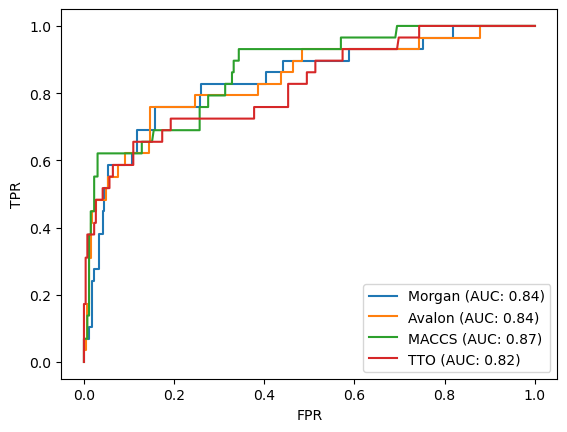

In [70]:
# Get ROC curves
morgan_fpr, morgan_tpr, _ = metrics.roc_curve(y_test, rf_predictions_morgan)
morgan_roc_auc = metrics.auc(morgan_fpr, morgan_tpr)

avalon_fpr, avalon_tpr, _ = metrics.roc_curve(y_test, rf_predictions_avalon)
avalon_roc_auc = metrics.auc(avalon_fpr, avalon_tpr)

maccs_fpr, maccs_tpr, _ = metrics.roc_curve(y_test, rf_predictions_maccs)
maccs_roc_auc = metrics.auc(maccs_fpr, maccs_tpr)

tto_fpr, tto_tpr, _ = metrics.roc_curve(y_test, rf_predictions_tto)
tto_roc_auc = metrics.auc(tto_fpr, tto_tpr)

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(morgan_fpr, morgan_tpr,
         label="Morgan (AUC: " + str(round(morgan_roc_auc*100)/100) + ")")
plt.plot(avalon_fpr, avalon_tpr,
         label="Avalon (AUC: " + str(round(avalon_roc_auc*100)/100) + ")")
plt.plot(maccs_fpr, maccs_tpr,
         label="MACCS (AUC: " + str(round(maccs_roc_auc*100)/100) + ")")
plt.plot(tto_fpr, tto_tpr,
         label="TTO (AUC: " + str(round(tto_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

# Plots per fingerprint

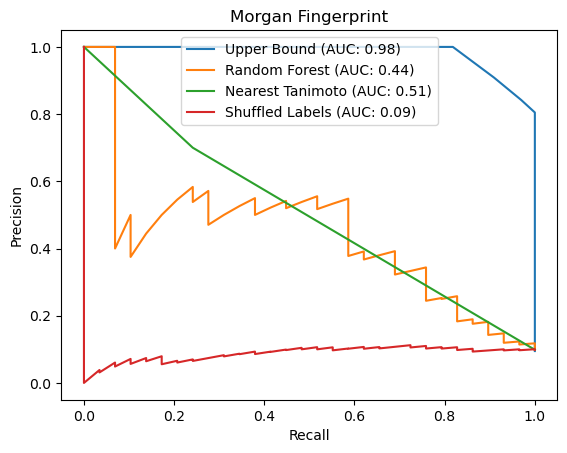

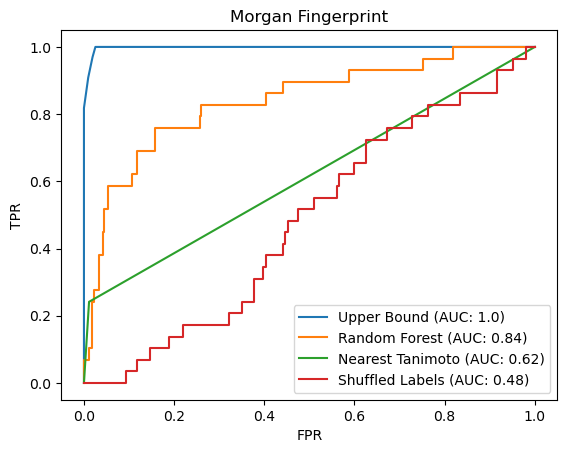

In [71]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Morgan Fingerprint")
plt.plot(morgan_upper_recall, morgan_upper_precision,
         label="Upper Bound (AUC: " + str(round(morgan_upper_rp_auc*100)/100) + ")")
plt.plot(morgan_recall, morgan_precision,
         label="Random Forest (AUC: " + str(round(morgan_rp_auc*100)/100) + ")")
plt.plot(morgan_lower_recall, morgan_lower_precision,
         label="Nearest Tanimoto (AUC: " + str(round(morgan_lower_rp_auc*100)/100) + ")")
plt.plot(morgan_shuffled_recall, morgan_shuffled_precision,
         label="Shuffled Labels (AUC: " + str(round(morgan_shuffled_rp_auc*100)/100) + ")")
plt.legend()
plt.show()
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("Morgan Fingerprint")
plt.plot(morgan_upper_fpr, morgan_upper_tpr,
         label="Upper Bound (AUC: " + str(round(morgan_upper_roc_auc*100)/100) + ")")
plt.plot(morgan_fpr, morgan_tpr,
         label="Random Forest (AUC: " + str(round(morgan_roc_auc*100)/100) + ")")
plt.plot(morgan_lower_fpr, morgan_lower_tpr,
         label="Nearest Tanimoto (AUC: " + str(round(morgan_lower_roc_auc*100)/100) + ")")
plt.plot(morgan_shuffled_fpr, morgan_shuffled_tpr,
         label="Shuffled Labels (AUC: " + str(round(morgan_shuffled_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

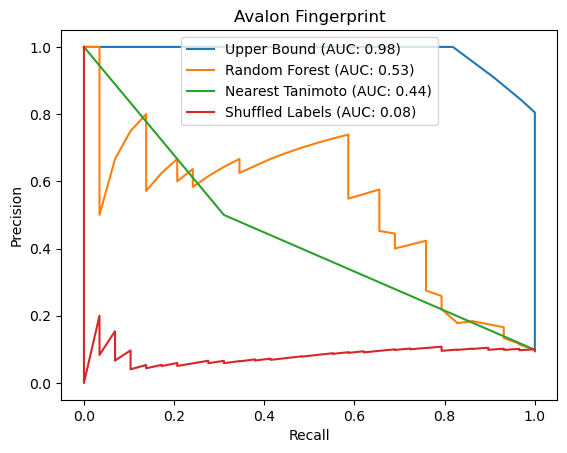

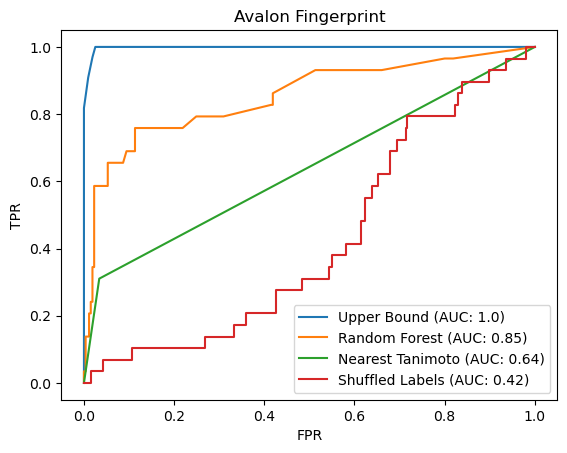

In [63]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Avalon Fingerprint")
plt.plot(avalon_upper_recall, avalon_upper_precision,
         label="Upper Bound (AUC: " + str(round(avalon_upper_rp_auc*100)/100) + ")")
plt.plot(avalon_recall, avalon_precision,
         label="Random Forest (AUC: " + str(round(avalon_rp_auc*100)/100) + ")")
plt.plot(avalon_lower_recall, avalon_lower_precision,
         label="Nearest Tanimoto (AUC: " + str(round(avalon_lower_rp_auc*100)/100) + ")")
plt.plot(avalon_shuffled_recall, avalon_shuffled_precision,
         label="Shuffled Labels (AUC: " + str(round(avalon_shuffled_rp_auc*100)/100) + ")")
plt.legend()
plt.show()
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("Avalon Fingerprint")
plt.plot(avalon_upper_fpr, avalon_upper_tpr,
         label="Upper Bound (AUC: " + str(round(avalon_upper_roc_auc*100)/100) + ")")
plt.plot(avalon_fpr, avalon_tpr,
         label="Random Forest (AUC: " + str(round(avalon_roc_auc*100)/100) + ")")
plt.plot(avalon_lower_fpr, avalon_lower_tpr,
         label="Nearest Tanimoto (AUC: " + str(round(avalon_lower_roc_auc*100)/100) + ")")
plt.plot(avalon_shuffled_fpr, avalon_shuffled_tpr,
         label="Shuffled Labels (AUC: " + str(round(avalon_shuffled_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

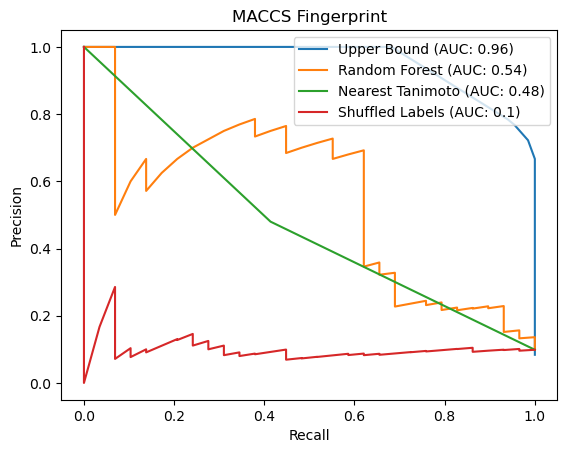

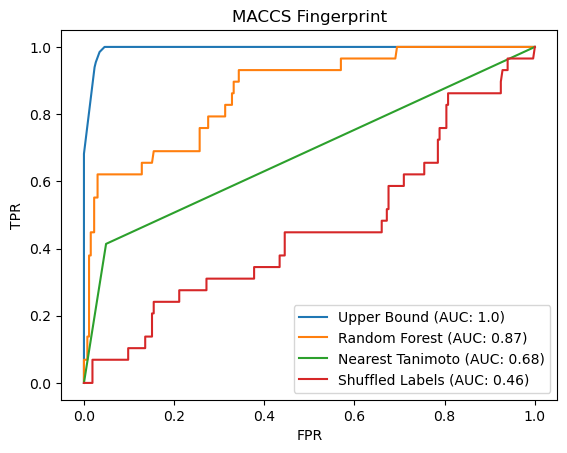

In [72]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("MACCS Fingerprint")
plt.plot(maccs_upper_recall, maccs_upper_precision,
         label="Upper Bound (AUC: " + str(round(maccs_upper_rp_auc*100)/100) + ")")
plt.plot(maccs_recall, maccs_precision,
         label="Random Forest (AUC: " + str(round(maccs_rp_auc*100)/100) + ")")
plt.plot(maccs_lower_recall, maccs_lower_precision,
         label="Nearest Tanimoto (AUC: " + str(round(maccs_lower_rp_auc*100)/100) + ")")
plt.plot(maccs_shuffled_recall, maccs_shuffled_precision,
         label="Shuffled Labels (AUC: " + str(round(maccs_shuffled_rp_auc*100)/100) + ")")
plt.legend()
plt.show()
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("MACCS Fingerprint")
plt.plot(maccs_upper_fpr, maccs_upper_tpr,
         label="Upper Bound (AUC: " + str(round(maccs_upper_roc_auc*100)/100) + ")")
plt.plot(maccs_fpr, maccs_tpr,
         label="Random Forest (AUC: " + str(round(maccs_roc_auc*100)/100) + ")")
plt.plot(maccs_lower_fpr, maccs_lower_tpr,
         label="Nearest Tanimoto (AUC: " + str(round(maccs_lower_roc_auc*100)/100) + ")")
plt.plot(maccs_shuffled_fpr, maccs_shuffled_tpr,
         label="Shuffled Labels (AUC: " + str(round(maccs_shuffled_roc_auc*100)/100) + ")")
plt.legend()
plt.show()

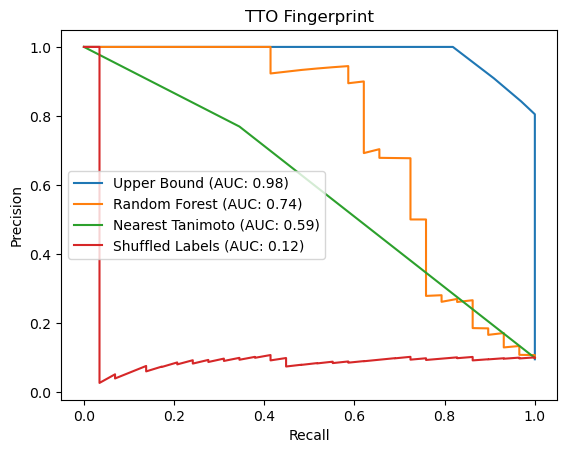

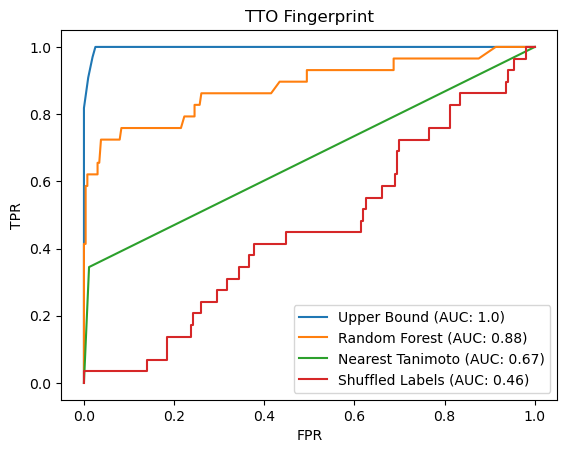

In [65]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("TTO Fingerprint")
plt.plot(tto_upper_recall, tto_upper_precision,
         label="Upper Bound (AUC: " + str(round(tto_upper_rp_auc*100)/100) + ")")
plt.plot(tto_recall, tto_precision,
         label="Random Forest (AUC: " + str(round(tto_rp_auc*100)/100) + ")")
plt.plot(tto_lower_recall, tto_lower_precision,
         label="Nearest Tanimoto (AUC: " + str(round(tto_lower_rp_auc*100)/100) + ")")
plt.plot(tto_shuffled_recall, tto_shuffled_precision,
         label="Shuffled Labels (AUC: " + str(round(tto_shuffled_rp_auc*100)/100) + ")")
plt.legend()
plt.show()
plt.figure()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("TTO Fingerprint")
plt.plot(tto_upper_fpr, tto_upper_tpr,
         label="Upper Bound (AUC: " + str(round(tto_upper_roc_auc*100)/100) + ")")
plt.plot(tto_fpr, tto_tpr,
         label="Random Forest (AUC: " + str(round(tto_roc_auc*100)/100) + ")")
plt.plot(tto_lower_fpr, tto_lower_tpr,
         label="Nearest Tanimoto (AUC: " + str(round(tto_lower_roc_auc*100)/100) + ")")
plt.plot(tto_shuffled_fpr, tto_shuffled_tpr,
         label="Shuffled Labels (AUC: " + str(round(tto_shuffled_roc_auc*100)/100) + ")")
plt.legend()
plt.show()